### <Center> Лабораторна робота №5. <br> Аналіз демографічних даних

**У завданні Вам пропонується навчити і налаштувати дерева і (при бажанні) випадковий ліс в завданні класифікації на даних Adult сховища UCI.**

Підключаємо необхідні бібліотеки

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Спочатку налаштуємо доступ до даних на google drive (якщо ви відкриваєте блокнот в google colab, а не на PC) шляхом монтування google drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


Перевіримо шлях до папки з матеріалами лаборатоної роботи на google drive. Якщо у вас шлях відрізняється то відредагуйте

In [ ]:
!ls gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lab_topic_3/data	

adult.data.csv	adult_test.csv	adult_train.csv  telecom_churn.csv


Перемістимо матеріали лабораторної роботи з google drive на віртуальну машину google colab

In [ ]:
!cp -a gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lab_topic_3/. .
!ls

data	lab0_intro_decision_tree.ipynb	lab5_decision_trees.ipynb
gdrive	lab0_intro_decision_tree.pdf	sample_data


**Опис набору даних**

 **[Набір] (http://archive.ics.uci.edu/ml/machine-learning-databases/adult) даних UCI Adult** (качати не треба, все є в репозиторії): класифікація людей за допомогою демографічних даних для прогнозування чи заробляє людина більш \ $ 50 000 в рік.

Опис ознак:

**Age** - вік, кількісна ознака

**Workclass** - тип роботодавця, кількісна ознака

**fnlwgt** - підсумковий вага об'єкта, кількісна ознака

**Education** - рівень освіти, якісна ознака

**Education_Num** - кількість років навчання, кількісна ознака

**Martial_Status** - сімейний стан, категоріальна ознака

**Occupation** - професія, категоріальна ознака

**Relationship** - тип сімейних відносин, категоріальна ознака

**Race** - раса, категоріальна ознака

**Sex** - стать, якісна ознака

**Capital_Gain** - приріст капіталу, кількісна ознака

**Capital_Loss** - втрати капіталу, кількісна ознака

**Hours_per_week** - кількість годин роботи в тиждень, кількісна ознака

**Country** - країна, категоріальна ознака
   
Цільова змінна: **Target** - рівень заробітку, категоріальна (бінарна) ознака

**Зчитуємо навчальну і тестову вибірки.**

In [ ]:
data_train = pd.read_csv('data/adult_train.csv', sep=';') 

In [ ]:
data_train.tail()

Age      Workclass  fnlwgt  ... Hours_per_week         Country  Target
32556   27        Private  257302  ...             38   United-States   <=50K
32557   40        Private  154374  ...             40   United-States    >50K
32558   58        Private  151910  ...             40   United-States   <=50K
32559   22        Private  201490  ...             20   United-States   <=50K
32560   52   Self-emp-inc  287927  ...             40   United-States    >50K

[5 rows x 15 columns]

In [ ]:
data_test = pd.read_csv('data/adult_test.csv', sep=';') 

In [ ]:
data_test.tail()

Age      Workclass    fnlwgt  ... Hours_per_week         Country   Target
16277  39        Private  215419.0  ...           36.0   United-States   <=50K.
16278  64            NaN  321403.0  ...           40.0   United-States   <=50K.
16279  38        Private  374983.0  ...           50.0   United-States   <=50K.
16280  44        Private   83891.0  ...           40.0   United-States   <=50K.
16281  35   Self-emp-inc  182148.0  ...           60.0   United-States    >50K.

[5 rows x 15 columns]

In [ ]:
# необхідно прибрати рядки з неправильними мітками в тестовій вибірці
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодуємо target в числове поле
data_train.at[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.at[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.at[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.at[data_test['Target'] == ' >50K.', 'Target'] = 1

**Первинний аналіз даних.**

In [ ]:
data_test.describe(include='all').T

count unique                  top  ...     50%     75%         max
Age             16281     73                   35  ...     NaN     NaN         NaN
Workclass       15318      8              Private  ...     NaN     NaN         NaN
fnlwgt          16281    NaN                  NaN  ...  177831  238384  1.4904e+06
Education       16281     16              HS-grad  ...     NaN     NaN         NaN
Education_Num   16281    NaN                  NaN  ...      10      12          16
Martial_Status  16281      7   Married-civ-spouse  ...     NaN     NaN         NaN
Occupation      15315     14       Prof-specialty  ...     NaN     NaN         NaN
Relationship    16281      6              Husband  ...     NaN     NaN         NaN
Race            16281      5                White  ...     NaN     NaN         NaN
Sex             16281      2                 Male  ...     NaN     NaN         NaN
Capital_Gain    16281    NaN                  NaN  ...       0       0       99999
Capital_Loss    16281    NaN                  NaN  ...       0       0        3770
Hours_per_week  16281    NaN                  NaN  ...      40      45          99
Country         16007     40        United-States  ...     NaN     NaN         NaN
Target          16281      2                    0  ...     NaN     NaN         NaN

[15 rows x 11 columns]

In [ ]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

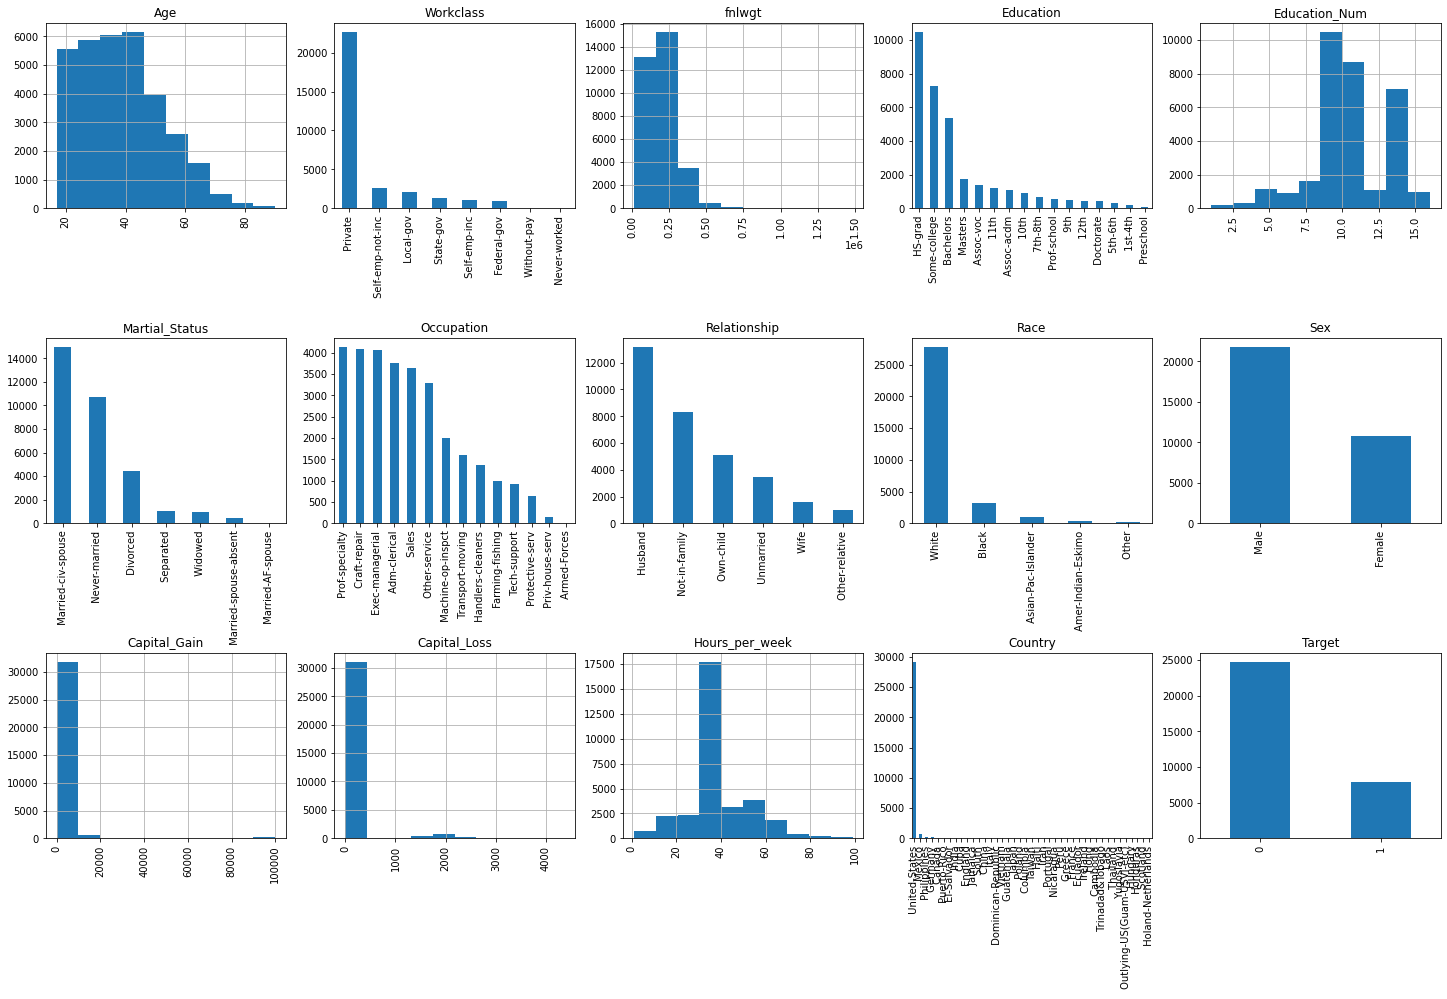

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Перевіряємо типи даних**

In [ ]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [ ]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

З'ясувалося, що в тесті вік віднесений до типу object, необхідно це виправити.

In [ ]:
data_test['Age'] = data_test['Age'].astype(int)

Також подамо показники типу float як int для відповідності train і test вибірок.

In [ ]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заповнимо пропуски в кількісних полях медіанним значенням, а в категоріальних -  значенням, що найчастіше зустрічається**

In [ ]:
# виділимо в вибірках категоріальні і числові поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [ ]:
# заповнимо пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

**Кодуємо категоріальні ознаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Це можна зробити за допомогою методу `pandas get_dummies`.**

In [ ]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [ ]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [ ]:
data_test.describe(include='all').T

count           mean  ...       75%        max
Age                       16281.0      38.767459  ...      48.0       90.0
fnlwgt                    16281.0  189435.677784  ...  238384.0  1490400.0
Education_Num             16281.0      10.072907  ...      12.0       16.0
Capital_Gain              16281.0    1081.905104  ...       0.0    99999.0
Capital_Loss              16281.0      87.899269  ...       0.0     3770.0
...                           ...            ...  ...       ...        ...
Country_ Thailand         16281.0       0.000737  ...       0.0        1.0
Country_ Trinadad&Tobago  16281.0       0.000491  ...       0.0        1.0
Country_ United-States    16281.0       0.900559  ...       1.0        1.0
Country_ Vietnam          16281.0       0.001167  ...       0.0        1.0
Country_ Yugoslavia       16281.0       0.000430  ...       0.0        1.0

[105 rows x 8 columns]

In [ ]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [ ]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**У тестовій вибірці не виявилося Голландії. Заведемо необхідну ознаку з нулів.**

In [ ]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [ ]:
set(data_train.columns) - set(data_test.columns)

set()

In [ ]:
data_train.head(2)

Age  fnlwgt  ...  Country_ Vietnam  Country_ Yugoslavia
0   39   77516  ...                 0                    0
1   50   83311  ...                 0                    0

[2 rows x 106 columns]

In [ ]:
data_test.head(2)

Age  fnlwgt  ...  Country_ Yugoslavia  Country_ Holand-Netherlands
1   25  226802  ...                    0                          0.0
2   38   89814  ...                    0                          0.0

[2 rows x 106 columns]

In [ ]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## Дерево рішень без налаштування параметрів

**Навчіть на наявній вибірці дерево рішень (`DecisionTreeClassifier`) максимальної глибини 3 і отримайте якість на тесті. Використовуйте параметр `random_state` = 17 для відтворюваності результатів.**

In [ ]:
tree = # Ваш код тут
tree.fit # Ваш код тут

**Зробіть за допомогою отриманої моделі прогноз для тестової вибірки.**

In [ ]:
tree_predictions = tree.predict # Ваш код тут

In [ ]:
accuracy_score # Ваш код тут

<font color='red'>Питання 6.  </font> Яка частка правильних відповідей дерева рішень на тестовій вибірці при максимальній глибині дерева = 3 і random_state = 17?

## Дерево рішень з налаштуванням параметрів

**Навчіть на наявній вибірці дерево рішень (`DecisionTreeClassifier`, знову` random_state` = 17). Максимальну глибину налаштуйте на крос-валідації за допомогою `GridSearchCV`. Проведіть 5-кратну крос-валідацію**

In [ ]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV # Ваш код тут                    

locally_best_tree.fit # Ваш код тут

In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

**Навчіть на наявній вибірці дерево рішень максимальної глибини 9 (це краще значення `max_depth` в моєму випадку) та оцініть частку правильних відповідей на тесті. Використовуйте параметр random_state = 17 для відтворюваності результатів.**

In [ ]:
tuned_tree = # Ваш код тут
tuned_tree.fit # Ваш код тут
tuned_tree_predictions = tuned_tree.predict # Ваш код тут
accuracy_score # Ваш код тут

<font color='red'>Питання 7.  </font> Яка частка правильних відповідей дерева рішень на тестовій вибірці при максимальній глибині дерева = 9 і random_state = 17?

## 2.3. Випадковий ліс без налаштування параметрів (опціонально) ¶

**Навчіть на наявній вибірці випадковий ліс (`RandomForestClassifier`), число дерев зробіть рівним ста, а` random_state` = 17.**

In [ ]:
rf = # Ваш код тут
rf.fit # Ваш код тут

**Зробіть за допомогою отриманої моделі прогноз для тестової вибірки.**

In [ ]:
forest_predictions = rf.predict # Ваш код тут

In [ ]:
accuracy_score # Ваш код тут

## 2.4. Випадковий ліс з налаштуванням параметрів 

**Навчіть на наявній вибірці випадковий ліс (`RandomForestClassifier`). Максимальну глибину і максимальне число ознак для кожного дерева налаштуйте за допомогою GridSearchCV.**

In [ ]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 10)}

locally_best_forest = GridSearchCV # Ваш код тут

locally_best_forest.fit # Ваш код тут

In [ ]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

**Зробіть за допомогою отриманої моделі прогноз для тестової вибірки.**

In [ ]:
tuned_forest_predictions = locally_best_forest.predict # Ваш код тут
accuracy_score # Ваш код тут